In [1]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# import all we need
from matplotlib import image
from matplotlib import pyplot
import time
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd 
import cv2
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [2]:
# set up dir of data
base_dir = '../plant-seedlings-classification/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
# the 12 species
classes = os.listdir(train_dir)
# parameter
batch_size = 32
IMG_SHAPE = 150 

In [3]:
#read training set
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = train_dir
classes = os.listdir(train_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()
X=[]
y=[]

for categories, label in training_data:
    y.append(label)
    X.append(categories)

In [4]:
#read val set
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = val_dir
classes = os.listdir(val_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

val_data=[]
def create_val_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                val_data.append([new_array,class_num])
            except Exception as e:
                pass
create_val_data()
X_val=[]
y_val=[]

for categories, label in val_data:
    y_val.append(label)
    X_val.append(categories)


In [5]:
X=np.array(X)
y=np.array(y)
X_val=np.array(X_val)
y_val=np.array(y_val)

In [6]:
#over_sample the training set

ReX_train = X.reshape(3801, 150 * 150 * 3)
X_resampled, y_resampled = SMOTE().fit_resample(ReX_train, y)
X_resampled.shape

(6276, 67500)

In [7]:
X_resampled = X_resampled.reshape(6276, 150 , 150 , 3)

In [8]:
X_resampled.shape

(6276, 150, 150, 3)

[523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523]

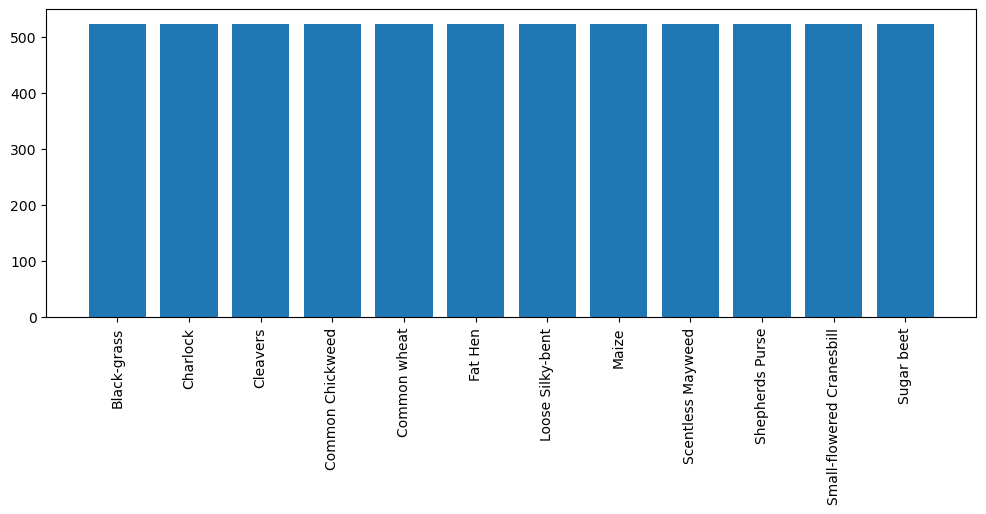

In [9]:
resamples_num = []
for i in range(12):
    x = np.count_nonzero(y_resampled == i)
    resamples_num.append(x)

fig = plt.figure(figsize=(12,4))
plt.bar(classes,resamples_num)
plt.xticks(rotation=-270)
resamples_num

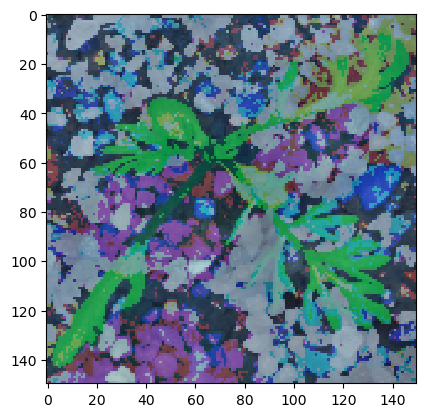

In [27]:
im = X_resampled[5555]
plt.imshow(im, interpolation='nearest')
plt.show()

In [10]:
#X_resampled = X_resampled/255

In [11]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_resampled)
# fits the model on batches with real-time data augmentation:
train_data_gen = datagen.flow(X_resampled, 
                              y_resampled,
                              shuffle=True,
                              batch_size=batch_size)

In [12]:
image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_val.fit(X_val)
val_data_gen = image_gen_val.flow(X_val,
                                  y_val,
                                  batch_size=batch_size)

In [19]:
# model
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SHAPE,IMG_SHAPE,3)
)
split_at = 80
for layer in base_model.layers[:split_at]:
  layer.trainable = False
for layer in base_model.layers[split_at:]:
  layer.trainable = True

In [20]:
len(base_model.layers)

86

In [21]:
x = layers.GlobalAveragePooling2D()(base_model.output)

predictions = layers.Dense(12, activation = 'softmax')(x)

In [22]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

EPOCHS = 35

In [23]:
head_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 9, 9, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 9, 9, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 9, 9, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 9, 9, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 9, 9, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 9, 9, 512)         262144    
                                                                 
 conv_pw_9

In [24]:
history = head_model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Epoch 1/35
197/197 [==============================] - 117s 587ms/step - loss: 1.7184 - accuracy: 0.4892 - val_loss: 1.5069 - val_accuracy: 0.6630
Epoch 2/35
197/197 [==============================] - 118s 600ms/step - loss: 1.1958 - accuracy: 0.6020 - val_loss: 0.8873 - val_accuracy: 0.7193
Epoch 3/35
197/197 [==============================] - 117s 594ms/step - loss: 1.0451 - accuracy: 0.6485 - val_loss: 1.5060 - val_accuracy: 0.6796
Epoch 4/35
197/197 [==============================] - 120s 607ms/step - loss: 0.9981 - accuracy: 0.6600 - val_loss: 0.8330 - val_accuracy: 0.7230
Epoch 5/35
197/197 [==============================] - 118s 599ms/step - loss: 0.9186 - accuracy: 0.6813 - val_loss: 1.0332 - val_accuracy: 0.7356
Epoch 6/35
197/197 [==============================] - 123s 627ms/step - loss: 0.8896 - accuracy: 0.6906 - val_loss: 0.5877 - val_accuracy: 0.8090
Epoch 7/35
197/197 [==============================] - 119s 604ms/step - loss: 0.8753 - accuracy: 0.7035 - val_loss: 0.8126 -

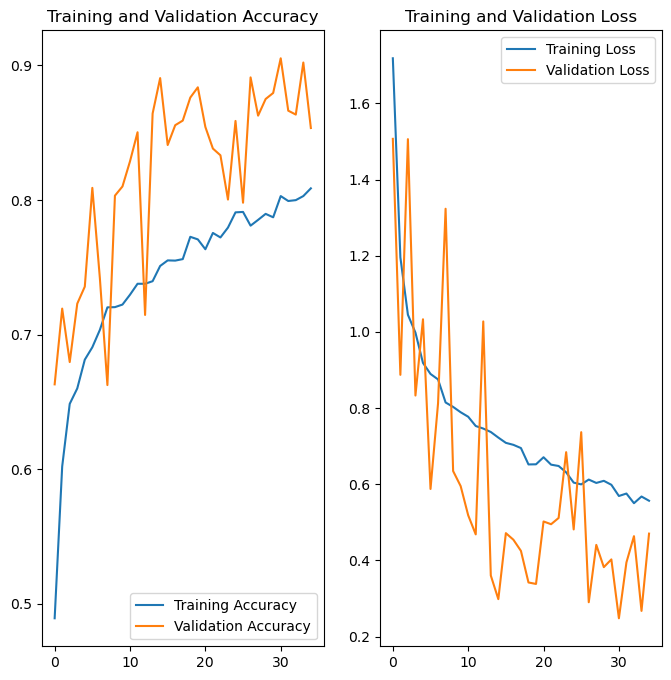

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
t = time.time()

export_path_keras = "./M1/{}.h5".format(int(t))
print(export_path_keras)

head_model.save(export_path_keras)

./M1/1672554777.h5


In [6]:
# reload
reloaded = tf.keras.models.load_model(
  './M1/1672554777.h5', 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

#reloaded.summary()

In [7]:
# predict the testdata
test_dir = '../plant-seedlings-classification/test'
testdata_dir = test_dir + '/testdata'
le = LabelEncoder()
le.fit(os.listdir(train_dir))
testdata = os.listdir(testdata_dir)

In [29]:
test_tal_num = 0
im = []
allimages= []
img_path = os.path.join(test_dir, 'testdata')
images = glob.glob(img_path + '/*.png')
allimages.extend(images)
#print("{}: {} Images".format(cl, len(images)))
test_tal_num += len(images)
#num_train = int(round(len(images)*0.8))
#train, val = images[:num_train], images[num_train:]

In [31]:
for i in range(len(images)):
    img = cv2.imread(allimages[i])
    img = tf.image.resize(img, [150,150])
    im.append(img)

In [32]:
im = np.array(im)/255.0

In [33]:
predictions = reloaded.predict(im)

25/25 [==============================] - 7s 245ms/step


In [34]:
results = []
for i in range(predictions.shape[0]):
    results.append(np.argmax(predictions[i]))

In [35]:
PredStr = list(le.inverse_transform(results))

In [36]:
result = {'file':testdata,'species':PredStr}
result = pd.DataFrame(result)
result.to_csv("Prediction_M1.csv",index=False)
#score : 0.79

In [8]:
# confution matrix
X_val = X_val/255

(949, 150, 150, 3)

In [9]:
prediction_val = reloaded.predict(X_val)

30/30 [==============================] - 7s 222ms/step


In [10]:
results_val = []
for i in range(prediction_val.shape[0]):
    results_val.append(np.argmax(prediction_val[i]))


In [14]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_val, results_val)

In [15]:
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

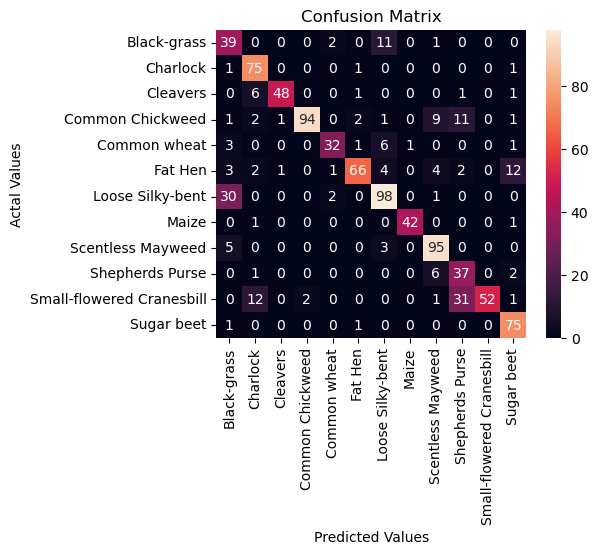

In [18]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
